Imports

In [1]:
import gym
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 10)

from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import Adam
from torch.distributions import Categorical
from torch.utils.data import TensorDataset, DataLoader

Our functions

In [2]:
from Train_policy_func import Policy, load_policy, evaluate_all_policies
from Generate_traj_func import generate_trajectory
from Plot_Functions import plot_suboptimality, plot_trajectory_performance, plot_Scores, plot_suboptimality_three_policies, plot_scores_RLHF
from OPPO import baseline_Acrobot_v0, OPPO_update_Acrobot, set_seed
from PPO import evaluate_policy
from pairs_generator import sample_preference_pairs
from RLHF import RewardModel_Acro, train_policy_from_rollouts_n_updates, train_policy_from_rollouts_n_updates_v2



In [3]:
class ShapedAcrobot(gym.Wrapper):
    def __init__(self, env, alpha=1.0, gamma=0.99):
        super().__init__(env)
        self.alpha, self.gamma = alpha, gamma
        self.last_pot = None

    def _potential(self, obs):
        c1, s1, c2, s2, a1, a2 = obs
        c12 = c1*c2 - s1*s2
        # normalized tip height in [–1,1]:
        return -(c1 + c12) / 2.0

    def reset(self, **kwargs):
        obs = self.env.reset(**kwargs)
        self.last_pot = self._potential(obs)
        return obs

    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        # compute shaping term:
        pot = self._potential(obs)
        shaping = self.gamma * pot - self.last_pot
        shaped_reward = reward + self.alpha * shaping  #  -β*(θ̇1**2 + θ̇2**2)
        self.last_pot = pot
        return obs, shaped_reward, done, info




## Step 1:
Creating the policies of references, here for three different seeds.

The policies, for CartPole at least are optimised with an OPPO algorithm.
They are saved as "pi1\_ref\_{env_name}\_seed\_{seed}.pth" and "pi2\_ref\_{env_name}\_seed\_{seed}.pth"

For Pendulum, do not know.

In [4]:
env_name='Acrobot-v1-perso'
env = ShapedAcrobot(gym.make("Acrobot-v1"), alpha=1.0, gamma=0.99)
# env = gym.make(env_name)
obs_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

baseline = baseline_Acrobot_v0 
target_score =  -150

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ── Hyperparams for OPPO ──
lr_oppo                 = 0.003
n_episodes              = 3000 # keep same “number of iterations” for fair comparison
max_t                   = 500  # cap on steps per episode
print_every             = 50   # print every x episodes and avg also the score for every x episodes
gamma                   = 0.99


load_policies   = True

evaluate_pi_ref = False
plot_scores     = False
n_eval          = 100

Policy_list     = []
seeds_list      = [35, 42, 100] #TODO

for seed in seeds_list:
    set_seed(seed, env)

    if load_policies:
        print(fr"Loading pi_1 and pi_2 with {seed=}")
        pi_1 = load_policy(f"./Policies/pi1_ref_{env_name}_seed_{seed}.pth", obs_dim, action_dim, device)
        pi_2 = load_policy(f"./Policies/pi2_ref_{env_name}_seed_{seed}.pth", obs_dim, action_dim, device)

    else:
        print(f"Training pi_1 and pi_2 with seed {seed}")

        pi_1 = Policy(state_size=obs_dim, action_size=action_dim).to(device)
        opt1 = torch.optim.Adam(pi_1.parameters(), lr=lr_oppo)


        scores_oppo = OPPO_update_Acrobot(
            policy          = pi_1,
            optimizer       = opt1,
            env             = env,
            baseline        = baseline,
            n_episodes      = n_episodes,
            max_t           = max_t,
            gamma           = gamma,      # you can reuse your PPO γ
            print_every     = print_every,
            early_stop      = False,
            seed            = seed,
            target_score    = target_score,
            env_name        = env_name,
            display_every   = False
        )


        pi_2 = load_policy(f"./Policies/pi2_ref_{env_name}_seed_{seed}.pth", obs_dim, action_dim, device)
    Policy_list.append([pi_1, pi_2])
    # print("------------------------------------------------------")

print("=================================")



Loading pi_1 and pi_2 with seed=35
Loading pi_1 and pi_2 with seed=42
Loading pi_1 and pi_2 with seed=100


C:\Users\turin\AppData\Roaming\Python\Python311\site-packages\gym\core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
C:\Users\turin\AppData\Roaming\Python\Python311\site-packages\gym\wrappers\step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
c:\Users\turin\OneDrive\EPFL\Master\MA2\RL\RLHF\Git RLHF\RL-RLHF\Train_policy_func.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://git

In [5]:
if evaluate_pi_ref:# ── Evaluate the policies ──
  print("Evaluating pi_1 and pi_2 for all seeds: \n")
  for seed, (pi_1, pi_2) in zip(seeds_list, Policy_list):
      
      print(f"Evaluating pi_1 and pi_2 with {seed=} over {n_eval} episodes")
      # Evaluate the policies
      seed_eval = seed+32
      _, pi1_rewards = evaluate_policy(pi_1, env, n_episodes=n_eval, seed=seed_eval)
      _, pi2_rewards = evaluate_policy(pi_2, env, n_episodes=n_eval, seed=seed_eval)
      print(f"Evaluations over {n_eval} episodes done for both policies, using the seed {seed}")
      print(f"\t pi_1({seed}) \t mean reward: \t {np.mean(pi1_rewards):.2f} ± {np.std(pi1_rewards):.2f}")
      print(f"\t pi_2({seed}) \t mean reward: \t {np.mean(pi2_rewards):.2f} ± {np.std(pi2_rewards):.2f}")

      if plot_scores:
          plot_Scores(
              pi1_rewards,
              pi2_rewards,
          )
      print("------------------------------------------------------")


  print("=================================")

### Now the Creation/loading of $\pi_{ref}^{1|2}$ is done
***
## We will implement the part RLHF

In [6]:
#Getting ride of potential 
env = gym.make("Acrobot-v1")

# RLHF hyperparameters
lr_RLHF              = 0.009 
n_rollouts_rlhf      = 20       # number of rollouts to collect for the reward model
K                    = 200
beta                 = 0.5
n_train_pi_rlhf      = 100      # very long time to train :)

# PPO-RLHF hyperparameters
lr_PPO_RLHF          = 0.003
n_ppo_updates        = 100      # number of PPO updates
# n_rollouts_ppo_rlhf  = 30       # number of rollouts to collect for the reward model; not used here
max_steps            = 2000      # max steps per episode
beta_ppo             = 5      # KL penalty coefficient
gamma_PPO            = 0.98
lambda_ppo           = 0.8 # 0.95
clip_eps             = 0.2
c1                   = 0.5         
c2                   = 0.0 # 0.1        
# rest of the parameters are the ones by default in PPO (see RLHF.py)


# Parameters for the RLHF part
Npairs_rm            = 200
n_pairs              = 300 # number of preference pairs to collect
load_RM              = True
load_rlhf_policies   = True
pi_ref_rlhf          = 1
load_pi2_start_rlhf  = True
plot_scores          = False
n_eval               = 100
compare_policies     = True
# Store the policies from RLHF learning
Policy_rlhf_list     = []
# Store the policies from PPO-RLHF learning
Policy_pporlhf_list  = []

policy_RLHF     = Policy(state_size= obs_dim, action_size= action_dim).to(device) #TODO
for seed, (pi_1, pi_2) in zip(seeds_list, Policy_list):
    # Create the policy that will be trained with RLHF
    policy_RLHF     = Policy(state_size= obs_dim, action_size= action_dim).to(device)
    policy_PPO_RLHF = Policy(state_size= obs_dim, action_size= action_dim).to(device)

    if load_rlhf_policies:
        # policy_RLHF     = load_policy(fr"./Policies/pi_RLHF_{env_name}_seed_{seed}_beta{beta}.pth", obs_dim, action_dim, device)
        policy_PPO_RLHF = load_policy(fr"./Policies/pi_PPO_RLHF_{env_name}_seed_{seed}_beta{beta_ppo}_Npairs_{Npairs_rm}.pth", obs_dim, action_dim, device)
        print(f"Loading policy trained with RLHF for {seed=}")
    else:
        # -- Creating the preference pairs -- 
        prefs = sample_preference_pairs(pi_1, pi_2, env, K=n_pairs)
        print(f"Collected {n_pairs} preference pairs for {seed=}.")
        
        # -- Reward model -- 
        # Create the reward model
        reward_model = RewardModel_Acro(state_dim=obs_dim, action_dim=action_dim).to(device)
        if load_RM:
            print(f"Loading reward model")
            reward_model.load_state_dict(torch.load(fr"./Policies/reward_model_{env_name}_Npairs_{Npairs_rm}.pth"))
        else:
            # Train the reward model
            print(f"Training reward model trained on {K} preference pairs")

        # -- Starting point of the policy --
        if load_pi2_start_rlhf: 
            # Starting point of the policy is pi_2
            policy_RLHF.load_state_dict(torch.load(fr"./Policies/pi2_ref_{env_name}_seed_{seed}.pth"))
            policy_PPO_RLHF.load_state_dict(torch.load(fr"./Policies/pi2_ref_{env_name}_seed_{seed}.pth"))
        opt_RLHF        = torch.optim.Adam(policy_RLHF.parameters(),     lr=lr_RLHF)
        opt_PPO_RLHF    = torch.optim.Adam(policy_PPO_RLHF.parameters(), lr=lr_PPO_RLHF)

        # -- Training the new policy --
        policy_ref = pi_1 if pi_ref_rlhf == 1 else pi_2

        # print(f"Training policy with RLHF using pi_{pi_ref_rlhf} as reference policy") #TODO
        # train_policy_from_rollouts_n_updates(policy_RLHF, policy_ref, reward_model, env, opt_RLHF, N=n_train_pi_rlhf, K=n_rollouts_rlhf, max_steps=500, beta=beta)
        # torch.save(policy_RLHF.state_dict(), fr"./Policies/pi_RLHF_{env_name}_seed_{seed}_beta{beta}.pth")
        # print(fr"Saved final policy in ./Policies/pi_RLHF_{env_name}_seed_{seed}_beta{beta}.pth")
        
        print(f"Training policy with PPO-RLHF using pi_{pi_ref_rlhf} as reference policy")
        train_policy_from_rollouts_n_updates_v2(policy_PPO_RLHF, policy_ref, reward_model, env, opt_PPO_RLHF, N=n_ppo_updates, max_steps=max_steps, beta=beta_ppo,gamma=gamma_PPO, lam=lambda_ppo, clip_eps=clip_eps, c1=c1, c2=c2)
        torch.save(policy_PPO_RLHF.state_dict(), fr"./Policies/pi_PPO_RLHF_{env_name}_seed_{seed}_beta{beta_ppo}_Npairs_{Npairs_rm}.pth")
        print(fr"Saved final policy in ./Policies/pi_PPO_RLHF_{env_name}_seed_{seed}_beta{beta_ppo}_Npairs_{Npairs_rm}.pth")
        
    Policy_rlhf_list.append(policy_RLHF)
    Policy_pporlhf_list.append(policy_PPO_RLHF)
print("=================================")



Loading policy trained with RLHF for seed=35
Loading policy trained with RLHF for seed=42
Loading policy trained with RLHF for seed=100


In [7]:
# if compare_policies:
#     print("Evaluating pi_RLHF and pi_PPO_RLHF for all seeds: \n")
#     for seed, (pi_1, pi_2), pi_rlhf, pi_ppo_rlhf in zip(seeds_list, Policy_list, Policy_rlhf_list, Policy_pporlhf_list):
        
#         seed_eval = seed+32
#         _, pi1_rewards          = evaluate_policy(pi_1,     env, n_episodes=n_eval, seed=seed_eval)
#         _, pi2_rewards          = evaluate_policy(pi_2,     env, n_episodes=n_eval, seed=seed_eval)
#         _, pi_rlhf_rewards      = evaluate_policy(pi_rlhf,  env, n_episodes=n_eval, seed=seed_eval)
#         _, pi_ppo_rlhf_rewards  = evaluate_policy(pi_ppo_rlhf, env, n_episodes=n_eval, seed=seed_eval)
        
#         print("Evaluations over", n_eval, "episodes done for the 4 policies, using the seed {seed}")
#         print(f"pi_1({seed})        \t mean reward: \t {np.mean(pi1_rewards):.2f} ± {np.std(pi1_rewards):.2f}")
#         print(f"pi_2({seed})        \t mean reward: \t {np.mean(pi2_rewards):.2f} ± {np.std(pi2_rewards):.2f}")
#         print(f"pi_RLHF({seed})     \t mean reward: \t {np.mean(pi_rlhf_rewards):.2f} ± {np.std(pi_rlhf_rewards):.2f}")
#         print(f"pi_PPO_RLHF({seed}) \t mean reward: \t {np.mean(pi_ppo_rlhf_rewards):.2f} ± {np.std(pi_ppo_rlhf_rewards):.2f}")
#         if plot_scores:
#             plot_scores_RLHF(pi2_rewards, pi1_rewards, pi_rlhf_rewards, algo="RLHF")

#         print("------------------------------------------------------")



***
## PPO-RLHF:

C:\Users\turin\AppData\Roaming\Python\Python311\site-packages\gym\utils\passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Evaluating pi_1, pi_2 and pi_PPO_RLHF with seed=35, beta=0.5 over 100 episodes


Evaluations over 100 episodes using the evalutation seed 67
pi_1(35)        	 mean reward: 	 -162.49 ± 34.10
pi_INIT(35)     	 mean reward: 	 -207.35 ± 48.43
pi_PPO_RLHF(35) 	 mean reward: 	 -165.96 ± 41.42


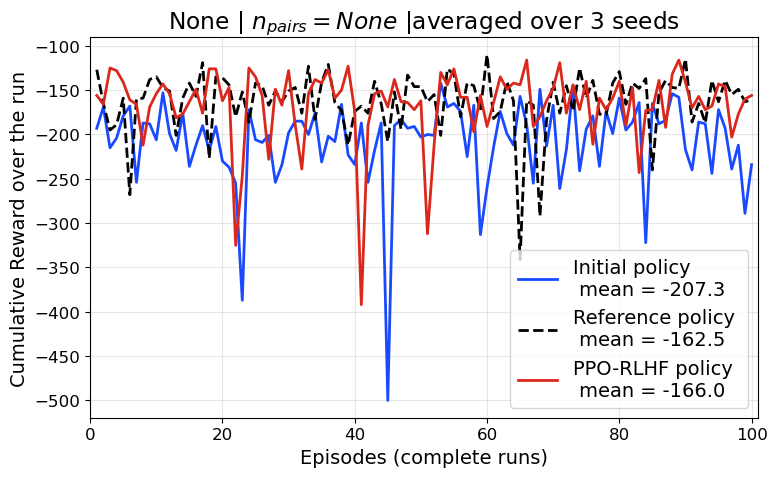

-------------------------------------
Evaluating pi_1, pi_2 and pi_PPO_RLHF with seed=42, beta=0.5 over 100 episodes
Evaluations over 100 episodes using the evalutation seed 74
pi_1(42)        	 mean reward: 	 -138.90 ± 25.74
pi_INIT(42)     	 mean reward: 	 -190.41 ± 42.71
pi_PPO_RLHF(42) 	 mean reward: 	 -145.04 ± 42.51


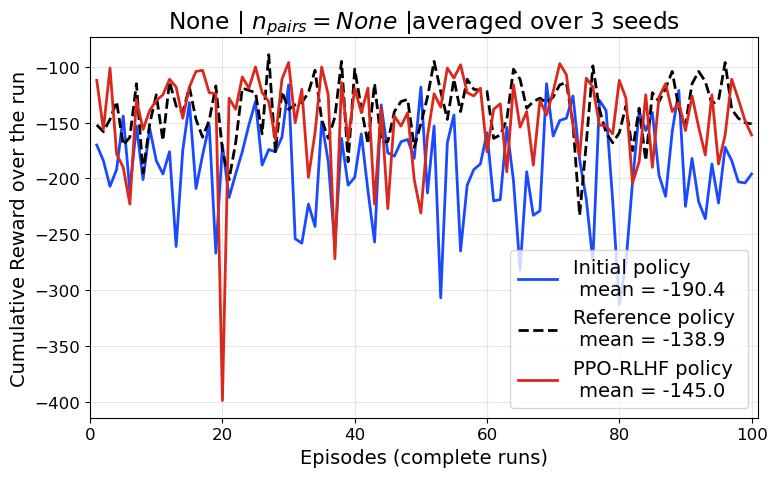

-------------------------------------
Evaluating pi_1, pi_2 and pi_PPO_RLHF with seed=100, beta=0.5 over 100 episodes
Evaluations over 100 episodes using the evalutation seed 132
pi_1(100)        	 mean reward: 	 -136.99 ± 62.28
pi_INIT(100)     	 mean reward: 	 -205.37 ± 53.65
pi_PPO_RLHF(100) 	 mean reward: 	 -127.41 ± 29.93


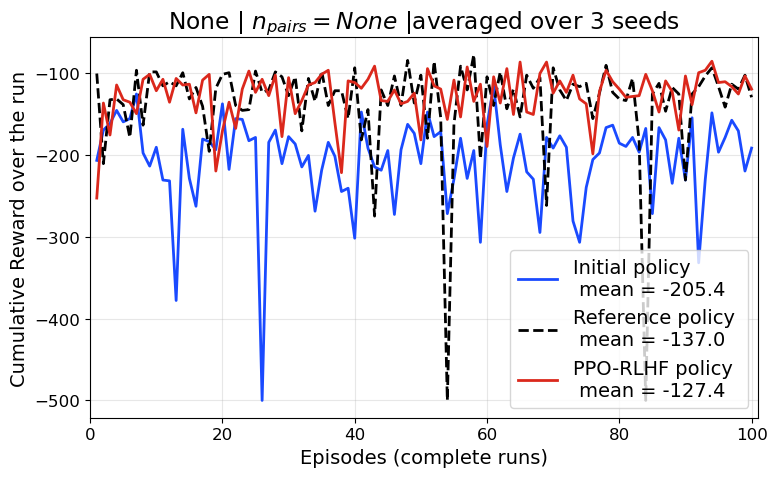

-------------------------------------


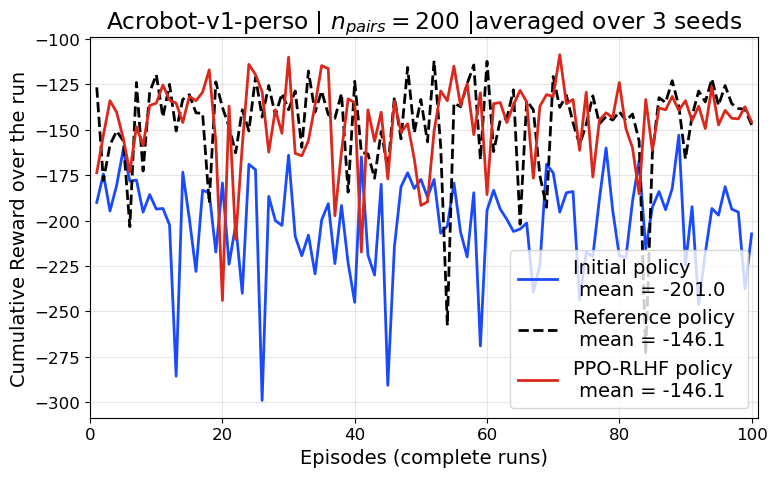

In [8]:
pi1_rewards_mean=np.zeros(n_eval)
pi2_rewards_mean=np.zeros(n_eval)
pi_rlhf_rewards_mean=np.zeros(n_eval)
for seed, (pi_1, pi_2), pi_rlhf in zip(seeds_list, Policy_list, Policy_pporlhf_list):
  print(f"Evaluating pi_1, pi_2 and pi_PPO_RLHF with {seed=}, {beta=} over {n_eval} episodes")
  # Evaluate the policies
  seed_eval = seed+32
  _, pi1_rewards     = evaluate_policy(pi_1,        env, n_episodes=n_eval, seed=seed_eval)
  _, pi_rlhf_rewards   = evaluate_policy(pi_rlhf,     env, n_episodes=n_eval, seed=seed_eval)
  _, pi2_rewards      = evaluate_policy(pi_2,       env, n_episodes=n_eval, seed=seed_eval)
  print(f"Evaluations over {n_eval} episodes using the evalutation seed {seed_eval}")
  print(f"pi_1({seed})        \t mean reward: \t {np.mean(pi1_rewards):.2f} ± {np.std(pi1_rewards):.2f}")
  print(f"pi_INIT({seed})     \t mean reward: \t {np.mean(pi2_rewards):.2f} ± {np.std(pi2_rewards):.2f}")
  print(f"pi_PPO_RLHF({seed}) \t mean reward: \t {np.mean(pi_rlhf_rewards):.2f} ± {np.std(pi_rlhf_rewards):.2f}")
  pi1_rewards_mean+=pi1_rewards
  pi2_rewards_mean+=pi2_rewards
  pi_rlhf_rewards_mean+=pi_rlhf_rewards

  plot_scores_RLHF(
      pi2_rewards,
      pi1_rewards,
      pi_rlhf_rewards,
      algo="PPO-RLHF"
  )
  print("-------------------------------------")
plot_scores_RLHF(
      pi2_rewards_mean/3,
      pi1_rewards_mean/3,
      pi_rlhf_rewards_mean/3,
      algo="PPO-RLHF",save=True, n_pair=Npairs_rm, env_name=env_name
  )